In [1]:
import np as np
import torch

In [2]:
data = torch.load("../filtered_preprocessed_images_with_metadata_and_target.pt.nosync")

features = []
metadata = []
y = []

for image, target, metadata_ in data:
    features.append(image)
    metadata.append(metadata_)
    y.append(target)

features = torch.tensor(np.array(features).reshape((-1, 1, 512, 512))).float()
metadata = torch.tensor(np.asarray(metadata).reshape((-1, 2))).float()
y = torch.tensor(y).view(-1, 1).float()

In [3]:
len(features)

676

In [4]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)


    def forward(self, x):
        out = self.up(x)
        return self.conv(out)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

""" Full assembly of the parts to form the complete network """

import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.n_channels = 1
        self.n_classes = 1


        self.inc = DoubleConv(self.n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        self.down4 = Down(128, 256)
        self.down5 = Down(256, 512)
        self.down6 = Down(512, 1024)
        self.down7 = Down(1024, 2048)
        self.adaptive_pool = nn.AdaptiveMaxPool2d(output_size=1)
        self.flatten = nn.Flatten()


    def forward(self, x):
        out = self.inc(x)
        out = self.down1(out)
        out = self.down2(out)
        out = self.down3(out)
        out = self.down4(out)
        out = self.down5(out)
        out = self.down6(out)
        out = self.down7(out)
        out = self.adaptive_pool(out)
        return self.flatten(out)

encoder = UNet()

In [5]:
state = torch.load("autoencoder_v3.pth", map_location=torch.device('cpu'))
state = {k: v for k, v in state.items() if not (k.startswith('up') or k.startswith('outc'))}
encoder.load_state_dict(state)

<All keys matched successfully>

In [6]:
output = encoder(features[:3])

In [7]:
output.shape

torch.Size([3, 2048])

In [8]:
import tqdm

extracted_features = []


for image in tqdm.tqdm(features):
    with torch.no_grad():
        extracted_feature = encoder((image * 255).unsqueeze(0))
    extracted_features.append(extracted_feature[0])

torch.save(extracted_features, "auto_encoder_extracted_features_small.pt.nosync")

100%|██████████| 676/676 [02:23<00:00,  4.71it/s]


In [9]:
extracted_features = torch.load("auto_encoder_extracted_features_small.pt.nosync")

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(np.asarray(extracted_features), y, random_state=3451, test_size=0.15)
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
len(X_train)

574

In [11]:
extracted_features[0].shape

torch.Size([2048])

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB

classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1_000),
    'SVM': SVC(max_iter=10_000, probability=True),
    'Random Forest': RandomForestClassifier(),
    'Complement Naive Bayes': ComplementNB()
}


# Create a function to train and evaluate classifiers
def train_and_evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_prob = np.asarray(classifier.predict_proba(X_test))[:, 1]

    f1 = probabilistic_f1(np.asarray(y_test), y_prob)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    auroc = roc_auc_score(y_test, y_prob, multi_class='ovr')

    return accuracy, precision, recall, f1, auroc


def probabilistic_f1(labels, predictions, beta=1):
    pTP = np.sum(labels * predictions)
    pFP = np.sum((1 - labels) * predictions)
    num_positives = np.sum(labels)  #  = pTP+pFN

    pPrecision = pTP / (pTP + pFP)
    pRecall = pTP / num_positives

    beta_squared = beta ** 2

    if pPrecision > 0 and pRecall > 0:
        pF1 = (1 + beta_squared) * pPrecision * pRecall / (beta_squared * pPrecision + pRecall)
        return pF1
    else:
        return 0


results = dict(zip(classifiers.keys(), [dict() for _ in range(len(classifiers))]))
for clf_name, clf in classifiers.items():
    print(clf_name)
    if clf_name == "Complement Naive Bayes":
        accuracy, precision, recall, f1, auroc = train_and_evaluate_classifier(clf, X_train + 1000, y_train.flatten(), X_test+1000, y_test.flatten())
    else:
        accuracy, precision, recall, f1, auroc = train_and_evaluate_classifier(clf, X_train, y_train.flatten(), X_test, y_test.flatten())


    results[clf_name]['Accuracy'] = accuracy
    results[clf_name]['Precision'] = precision
    results[clf_name]['Recall'] = recall
    results[clf_name]['F1 Score'] = f1
    results[clf_name]['AUROC'] = auroc

Logistic Regression
SVM
Random Forest
Complement Naive Bayes


In [25]:
results

{'Logistic Regression': {'Accuracy': 0.6688235294117647,
  'Precision': 0.6758791818614237,
  'Recall': 0.6688235294117647,
  'F1 Score': 0.6700872861332287,
  'AUROC': 0.6779347826086956},
 'SVM': {'Accuracy': 0.7080392156862744,
  'Precision': 0.7036703039424724,
  'Recall': 0.7080392156862744,
  'F1 Score': 0.6512323366721505,
  'AUROC': 0.7284006211180122},
 'Random Forest': {'Accuracy': 0.6884313725490195,
  'Precision': 0.6862170851785728,
  'Recall': 0.6884313725490195,
  'F1 Score': 0.6576606305726628,
  'AUROC': 0.6981211180124224},
 'Complement Naive Bayes': {'Accuracy': 0.6884313725490195,
  'Precision': 0.6825908273757263,
  'Recall': 0.6884313725490195,
  'F1 Score': 0.6334491476336653,
  'AUROC': 0.6290217391304348}}

In [26]:
import torch.nn as nn


class DeepNN(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # self.encoder = encoder

        self.seq_1 = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.Dropout(0.15),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        self.seq_2 = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, 1),
            nn.Sigmoid()
        )
        self.linear = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        out_1 = self.seq_1(x1)
        out_2 = self.seq_2(x2)

        out = torch.cat([out_1, out_2], dim=1)
        out = self.linear(out)
        out = self.sigmoid(out)
        return out

In [27]:
from torch.utils.data import TensorDataset, DataLoader

scaler = MinMaxScaler()

X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(scaler.fit_transform(extracted_features), metadata, y.float(), test_size=0.15, random_state=3451)

train_dataset = TensorDataset(torch.Tensor(np.asarray(X1_train)).float(), X2_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(torch.Tensor(np.asarray(X1_val)).float(), X2_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [29]:
np.min(X1_train), np.max(X1_train)

(0.0, 1.0000000000000002)

In [34]:
from torch import optim

# encoder = UNet()
# state = torch.load("autoencoder.pth", map_location=torch.device('cpu'))
# state = {k: v for k, v in state.items() if not (k.startswith('up') or k.startswith('outc'))}
# encoder.load_state_dict(state)
# for param in encoder.parameters():
#       param.requires_grad_(False)


model = DeepNN()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 300

train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in range(num_epochs):
    plt.clf()
    running_loss = 0.0
    model.train()  # Set the model to training mode
    train_predictions = []
    train_labels = []

    for i, data in enumerate(train_dataloader, 0):
        inputs1, inputs2, labels = data

        optimizer.zero_grad()

        outputs = model(inputs1, inputs2)
        loss = criterion(outputs, labels)

        train_predictions.extend(outputs.detach().numpy().flatten())
        train_labels.extend(labels.detach().numpy().flatten())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / (i + 1)
    train_losses.append(train_loss)
    train_f1 = probabilistic_f1(np.asarray(train_labels), np.round(train_predictions, decimals=2))
    train_f1_scores.append(train_f1)

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            inputs1, inputs2, labels = data

            outputs = model(inputs1, inputs2)
            loss = criterion(outputs, labels)

            val_predictions.extend(outputs.detach().numpy().flatten())
            val_labels.extend(labels.detach().numpy().flatten())

            val_loss += loss.item()

    val_loss = val_loss / (i + 1)
    val_losses.append(val_loss)
    val_f1 = probabilistic_f1(np.asarray(val_labels), np.asarray(val_predictions))
    val_f1_scores.append(val_f1)

    print(
        f'Epoch {epoch + 1}, Validation Loss: {round(val_loss, 3)}, F1 Score: {round(val_f1, 3)} Training Loss: {round(train_loss, 3)}, F1 Score: {round(train_f1, 3)}')


Epoch 1, Validation Loss: 0.713, F1 Score: 0.564 Training Loss: 0.717, F1 Score: 0.578
Epoch 2, Validation Loss: 0.699, F1 Score: 0.541 Training Loss: 0.692, F1 Score: 0.54
Epoch 3, Validation Loss: 0.697, F1 Score: 0.538 Training Loss: 0.691, F1 Score: 0.531
Epoch 4, Validation Loss: 0.7, F1 Score: 0.546 Training Loss: 0.691, F1 Score: 0.531
Epoch 5, Validation Loss: 0.697, F1 Score: 0.541 Training Loss: 0.691, F1 Score: 0.537
Epoch 6, Validation Loss: 0.697, F1 Score: 0.54 Training Loss: 0.69, F1 Score: 0.533
Epoch 7, Validation Loss: 0.698, F1 Score: 0.544 Training Loss: 0.689, F1 Score: 0.532
Epoch 8, Validation Loss: 0.698, F1 Score: 0.545 Training Loss: 0.69, F1 Score: 0.539
Epoch 9, Validation Loss: 0.694, F1 Score: 0.536 Training Loss: 0.689, F1 Score: 0.533
Epoch 10, Validation Loss: 0.7, F1 Score: 0.549 Training Loss: 0.69, F1 Score: 0.533
Epoch 11, Validation Loss: 0.695, F1 Score: 0.541 Training Loss: 0.689, F1 Score: 0.534
Epoch 12, Validation Loss: 0.695, F1 Score: 0.542 

<Figure size 640x480 with 0 Axes>

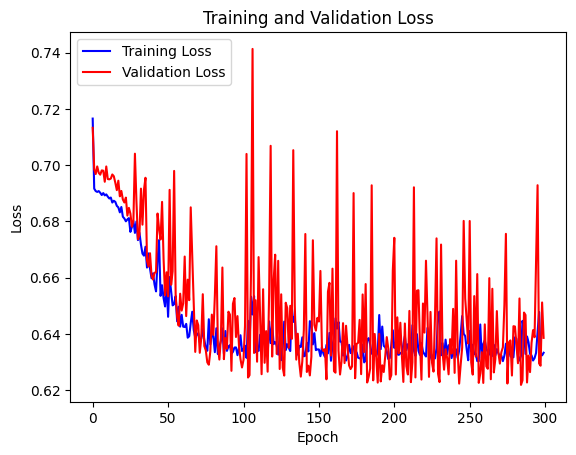

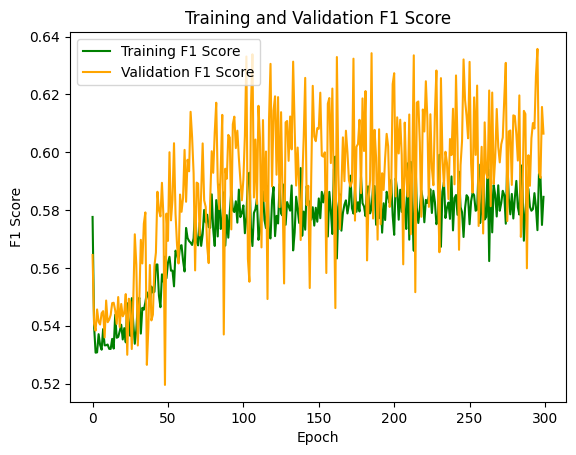

In [35]:
# Real-time visualization
plt.figure(1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.figure(2)
plt.plot(train_f1_scores, label='Training F1 Score', color='green')
plt.plot(val_f1_scores, label='Validation F1 Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='upper left')
plt.title('Training and Validation F1 Score')

plt.show(block=False)

y_pred = np.asarray(val_predictions) > 0.5
accuracy = accuracy_score(val_labels, y_pred)
precision = precision_score(val_labels, y_pred, average='weighted')
recall = recall_score(val_labels, y_pred, average='weighted')
auroc = roc_auc_score(val_labels, val_predictions, multi_class='ovr')

clf_name = "DeepNN - val"
results[clf_name] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': val_f1,
    'AUROC': auroc,
}
y_pred = np.asarray(train_predictions) > 0.5
accuracy = accuracy_score(train_labels, y_pred)
precision = precision_score(train_labels, y_pred, average='weighted')
recall = recall_score(train_labels, y_pred, average='weighted')
auroc = roc_auc_score(train_labels, train_predictions, multi_class='ovr')

clf_name = "DeepNN - train"
results[clf_name] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': train_f1,
    'AUROC': auroc,
}

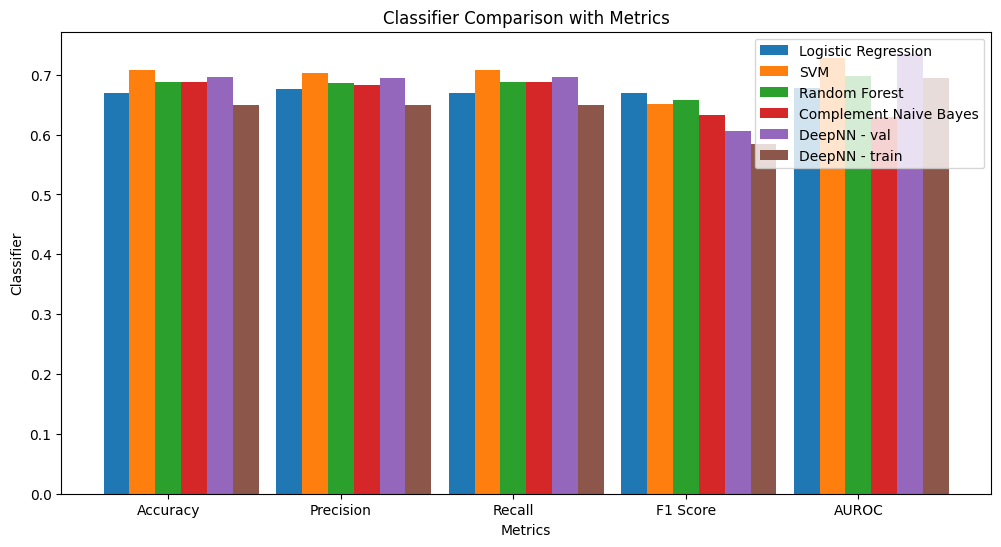

F1 Scores:
Logistic Regression: 0.6700872861332287
SVM: 0.6512323366721505
Random Forest: 0.6576606305726628
Complement Naive Bayes: 0.6334491476336653
DeepNN - val: 0.6064326921647506
DeepNN - train: 0.5845726692109084


In [36]:
import matplotlib as mpl

classifiers_list = list(results.keys())
metrics = list(results[classifiers_list[0]].keys())
colors = mpl.colormaps['tab10'].colors

plt.figure(figsize=(12, 6))
width = 0.15
x = np.arange(len(metrics))

for i, classifier in enumerate(classifiers_list):
    plt.bar(x + width * i, [results[classifier][metric] for metric in metrics], width, label=classifier,
            color=colors[i])

plt.ylabel('Classifier')
plt.xlabel('Metrics')
plt.title('Classifier Comparison with Metrics')
plt.xticks(x + width * 2, metrics)
plt.legend(loc='upper right')
plt.show()

print("F1 Scores:")
for clf_name, f1 in results.items():
    print(f"{clf_name}: {f1['F1 Score']}")
